In [2]:
pip install ISLP

Note: you may need to restart the kernel to use updated packages.


# 6.5.Lab: Linear Models and Regularization Methods

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path

     ---------------------------------------- 0.0/79.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/79.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/79.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/79.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/79.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/79.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/79.8 kB ? eta -:--:--
     ------------------------------ --------- 61.4/79.8 kB 3.2 MB/s eta 0:00:01
     ------------------------------ --------- 61.4/79.8 kB 3.2 MB/s eta 0:00:01
     ------------------------------ --------- 61.4/79.8 kB 3.2 MB/s eta 0:00:01
     ------------------------------ --------- 61.4/79.8 kB 3.2 MB/s eta 0:00:01
     ------------------------------ --------- 61.4/79.8 kB 3.2 MB/s eta 0:00:01
     -------------------------------------- 79.8/79.8 kB 297.4 kB/s eta 0:00:00
  Preparing meta

# 6.5.1 Subset Selection Methods

## Forward Selection

In [6]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

In [7]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

In [10]:
def nCp(sigma2 , estimator , X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [11]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [12]:
neg_Cp = partial(nCp , sigma2)

In [13]:
strategy = Stepwise.first_peak(design ,
direction='forward',
max_terms=len(design.terms))

In [14]:
hitters_MSE = sklearn_selected(OLS ,
strategy)
hitters_MSE.fit(Hitters , Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [15]:
hitters_Cp = sklearn_selected(OLS ,
strategy ,
scoring=neg_Cp)
hitters_Cp.fit(Hitters , Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

## Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [16]:
strategy = Stepwise.fixed_steps(design ,
len(design.terms),
direction='forward')
full_path = sklearn_selection_path(OLS , strategy)

In [17]:
full_path.fit(Hitters , Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

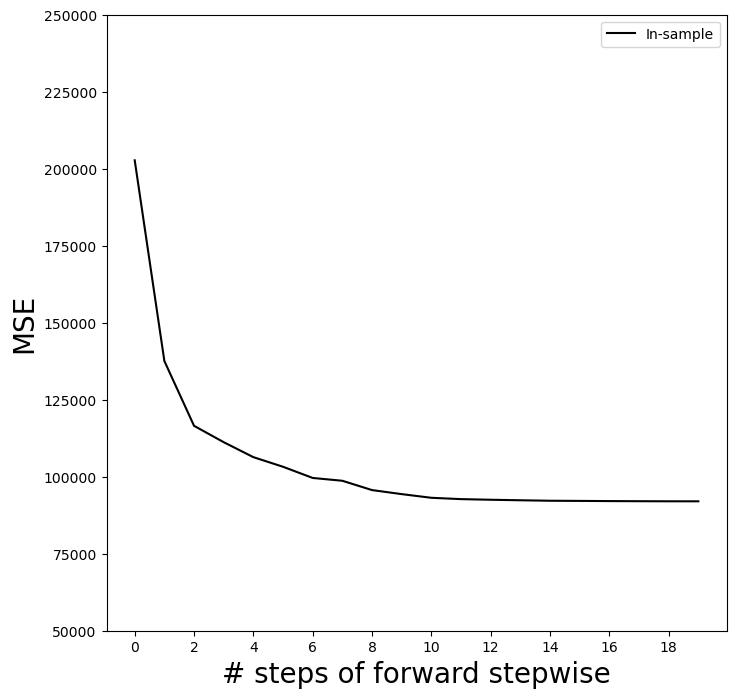

In [18]:
mse_fig , ax = subplots(figsize =(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In-sample')
ax.set_ylabel('MSE',
fontsize =20)
ax.set_xlabel('# steps of forward stepwise',
fontsize =20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim ([50000 ,250000]);

In [19]:
K = 5
kfold = skm.KFold(K,
random_state=0,
shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path ,
Hitters ,
Y,
cv=kfold)
Yhat_cv.shape

(263, 20)

In [21]:
cv_mse = []
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx ,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

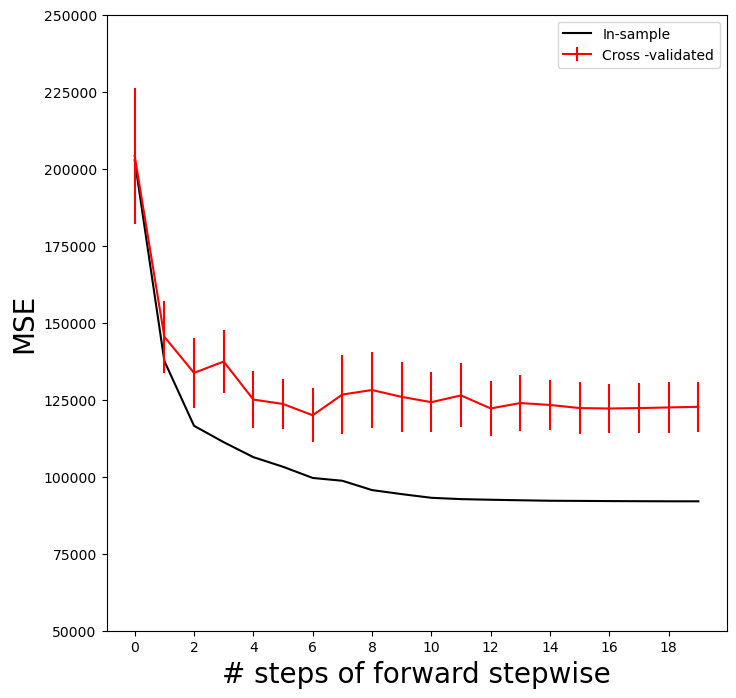

In [22]:
ax.errorbar(np.arange(n_steps),
cv_mse.mean(1),
cv_mse.std(1) / np.sqrt(K),
label='Cross -validated',
c='r') # color red
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

In [31]:
validation = skm.ShuffleSplit(n_splits=1, test_size =0.2,random_state =0)
for train_idx , test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx ,None])**2
    validation_mse = errors.mean(0)

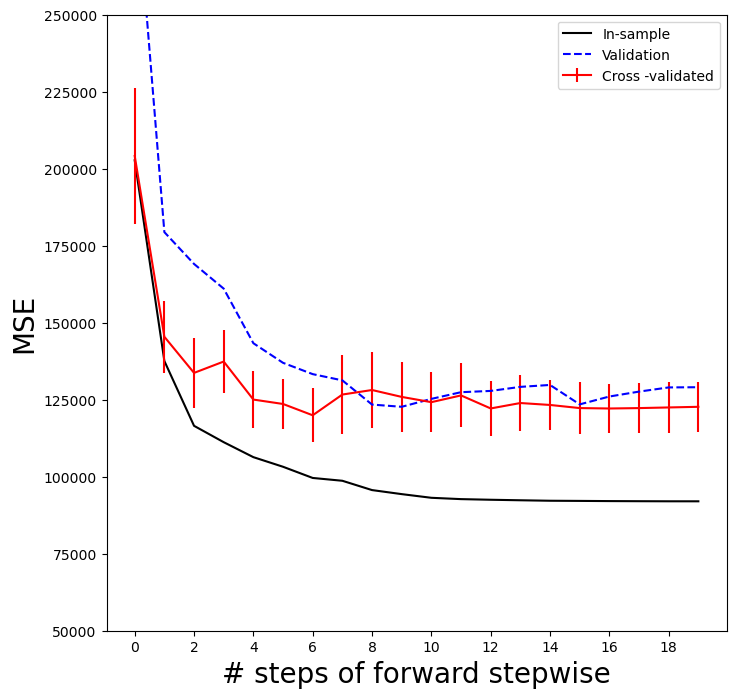

In [32]:
ax.plot(np.arange(n_steps),
validation_mse ,
'b--', # color blue , broken line
label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

## Best Subset Selection

In [33]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [34]:
path = fit_path(X,
Y,
max_nonzeros=X.shape [1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [35]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555494,
 'lambda_0': 0.011416248027450194,
 'M': 0.5829861733382014,
 'Time_exceeded': False}

## 6.5.2 Ridge Regression and the Lasso

### Ridge Regression

In [36]:
Xs = X - X.mean(0)[None ,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
Y,
l1_ratio=0.,
alphas=lambdas)[1]
soln_array.shape

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objecti

(19, 100)

In [37]:
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns ,
index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


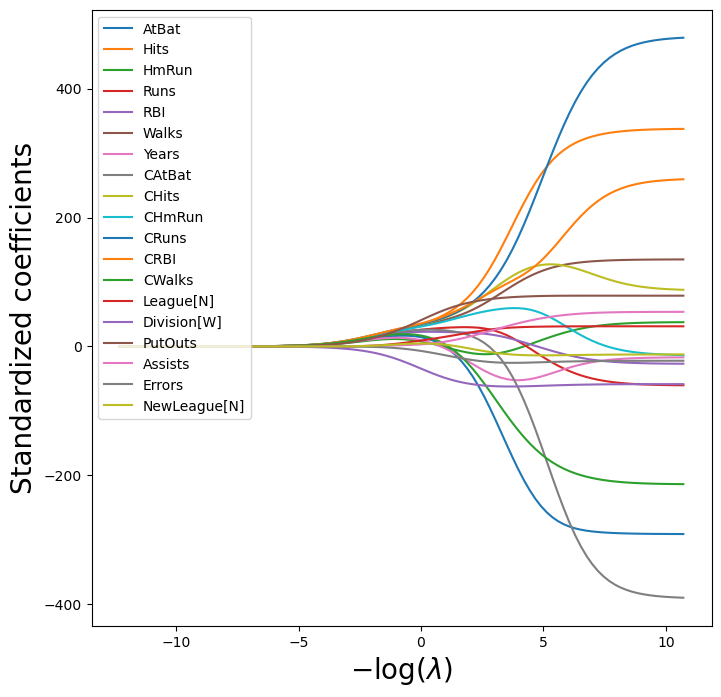

In [39]:
path_fig , ax = subplots(figsize =(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize =20)
ax.set_ylabel('Standardized coefficients', fontsize =20)
ax.legend(loc='upper left');

In [40]:
beta_hat = soln_path.loc[soln_path.index [39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [41]:
np.linalg.norm(beta_hat)

24.170617201443783

In [42]:
beta_hat = soln_path.loc[soln_path.index [59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725816)

In [43]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio =0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [44]:
np.linalg.norm(ridge.coef_)

160.42371017725932

### Estimating Test Error of Ridge Regression

In [47]:
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import Ridge

# Set up ShuffleSplit
validation = ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Define model
ridge = Ridge(alpha=0.01)

# Perform cross-validation with correct scoring name
results = cross_validate(
    ridge,
    X,
    Y,
    scoring='neg_mean_squared_error',
    cv=validation
)

# Print mean of test scores (remember: negative MSE)
print("Mean Negative MSE:", results['test_score'].mean())
print("Mean MSE:", -results['test_score'].mean())  # negate to get actual MSE


Mean Negative MSE: -134596.76230062297
Mean MSE: 134596.76230062297


In [49]:
ridge.alpha = 1e10

results = skm.cross_validate(
    ridge,
    X,
    Y,
    scoring='neg_mean_squared_error',  # ✅ No trailing space
    cv=validation
)

# Display the negative test scores (i.e., MSEs)
print(-results['test_score'])  # Converts negative MSE back to positive


[224042.3789389]


In [51]:
from sklearn.model_selection import GridSearchCV

# Assuming: 
# - 'pipe' is a pipeline that includes a step named 'ridge' (e.g., Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())]))
# - 'lambdas' is a list/array of alpha values to try
# - 'validation' is a CV splitter like ShuffleSplit
# - 'X' and 'Y' are your feature matrix and target vector

param_grid = {'ridge__alpha': lambdas}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=validation,
    scoring='neg_mean_squared_error'
)

grid.fit(X, Y)

# Best alpha value
best_alpha = grid.best_params_['ridge__alpha']
print("Best alpha:", best_alpha)

# Best model (pipeline with best alpha)
best_model = grid.best_estimator_
print("Best model:", best_model)


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

Best alpha: 0.005899006046740856
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.485e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.483e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

In [53]:
from sklearn.model_selection import GridSearchCV

# Assuming:
# - 'pipe' is a scikit-learn Pipeline with a step named 'ridge'
# - 'param_grid' is like: {'ridge__alpha': lambdas}
# - 'kfold' is a KFold or other cross-validation splitter
# - 'X' is your features, 'Y' is the target

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error'
)

grid.fit(X, Y)

# Get best alpha (lambda)
best_alpha = grid.best_params_['ridge__alpha']
print("Best alpha (ridge__alpha):", best_alpha)

# Get the best model (pipeline with tuned alpha)
best_model = grid.best_estimator_
print("Best pipeline:", best_model)


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

Best alpha (ridge__alpha): 0.01185247763144249
Best pipeline: Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.636e+06, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.897e+06, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

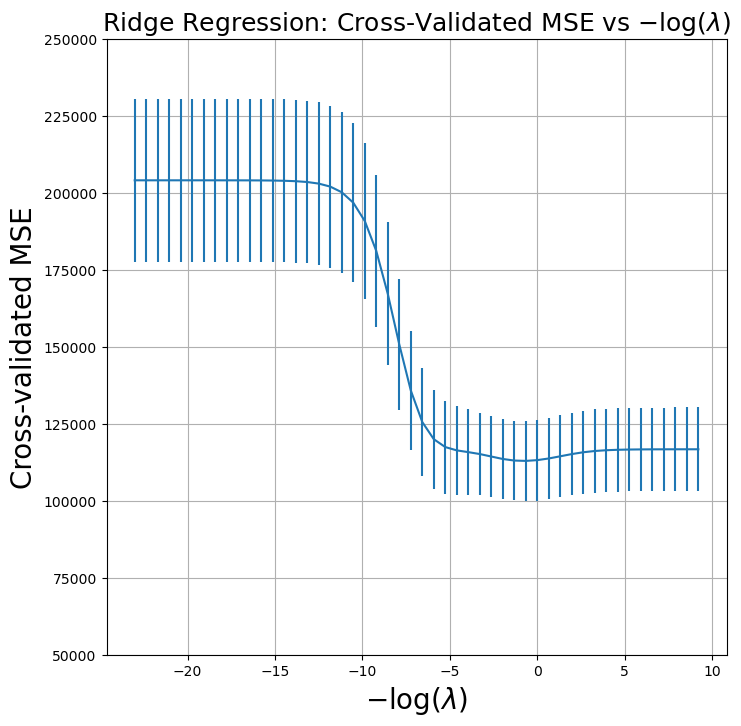

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

# Set up pipeline and data (you should already have X, Y defined)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define lambda values
lambdas = np.logspace(-4, 10, 50)
param_grid = {'ridge__alpha': lambdas}

# Define cross-validation strategy
K = 10
kfold = KFold(n_splits=K, shuffle=True, random_state=42)

# Run grid search
grid = GridSearchCV(pipe,
                    param_grid,
                    cv=kfold,
                    scoring='neg_mean_squared_error')
grid.fit(X, Y)

# Extract scores and params
mean_scores = -grid.cv_results_['mean_test_score']  # negate because score is negative MSE
std_scores = grid.cv_results_['std_test_score'] / np.sqrt(K)
lambdas = np.array(grid.cv_results_['param_ridge__alpha'], dtype=np.float64)

# Check dimensions
assert len(lambdas) == len(mean_scores), "Mismatch in x and y lengths"

# Plotting
ridge_fig, ax = plt.subplots(figsize=(8, 8))
ax.errorbar(-np.log(lambdas), mean_scores, yerr=std_scores)

ax.set_ylim([50000, 250000])
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_title('Ridge Regression: Cross-Validated MSE vs $-\\log(\\lambda)$', fontsize=18)
ax.grid(True)
plt.show()

## Fast Cross-Validation for Solution Paths

In [55]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
l1_ratio=0,
cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795326.35550233, tolerance: 3759.109166869192
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Object

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

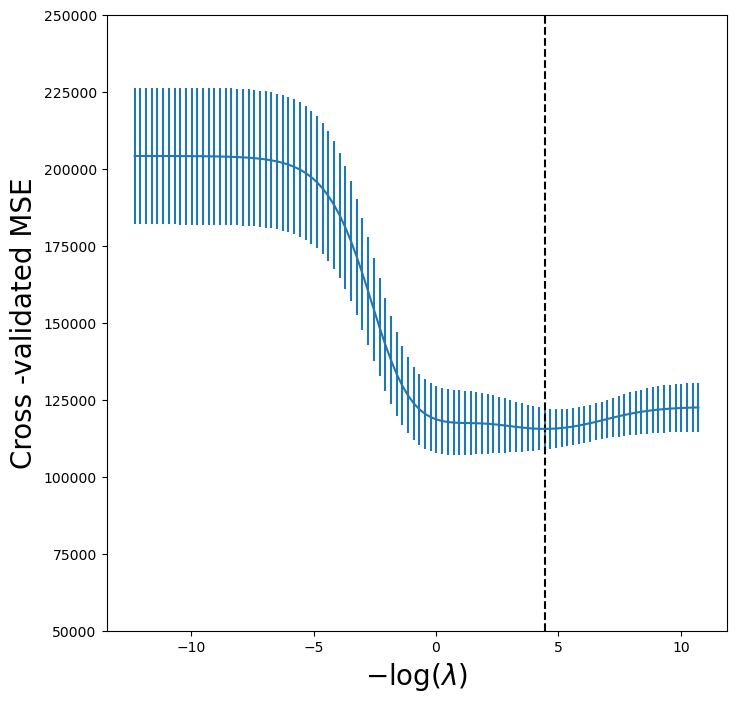

In [56]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig , ax = subplots(figsize =(8,8))
ax.errorbar(-np.log(lambdas),
tuned_ridge.mse_path_.mean(1),
yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize =20)
ax.set_ylabel('Cross -validated MSE', fontsize =20);

In [57]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987761

In [58]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

### Evaluating Test Error of Cross-Validated Ridge

In [62]:
outer_valid = skm.ShuffleSplit(n_splits=1,
test_size =0.25,
random_state =1)
inner_cv = skm.KFold(n_splits=5,
shuffle=True ,
random_state =2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
l1_ratio=0,
cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
('ridge', ridgeCV)]);
results = skm.cross_validate(
    pipeCV,
    X,
    Y,
    cv=outer_valid,
    scoring='neg_mean_squared_error'
)

# Get the negative MSE values and convert them to positive MSEs
mse_scores = -results['test_score']
mse_scores


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.893047338, tolerance: 3200.632555100493
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objec

array([132393.84003227])

In [61]:
results = skm.cross_validate(
    pipeCV,
    X,
    Y,
    cv=outer_valid,
    scoring='neg_mean_squared_error'
)

# Get the negative MSE values and convert them to positive MSEs
mse_scores = -results['test_score']
mse_scores


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.893047338, tolerance: 3200.632555100493
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objec

array([132393.84003227])

# The Lasso

In [63]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
l1_ratio=1,
cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649874

In [64]:
lambdas , soln_array = skl.Lasso.path(Xs,
Y,
l1_ratio=1,
n_alphas =100) [:2]
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns ,
index=-np.log(lambdas))

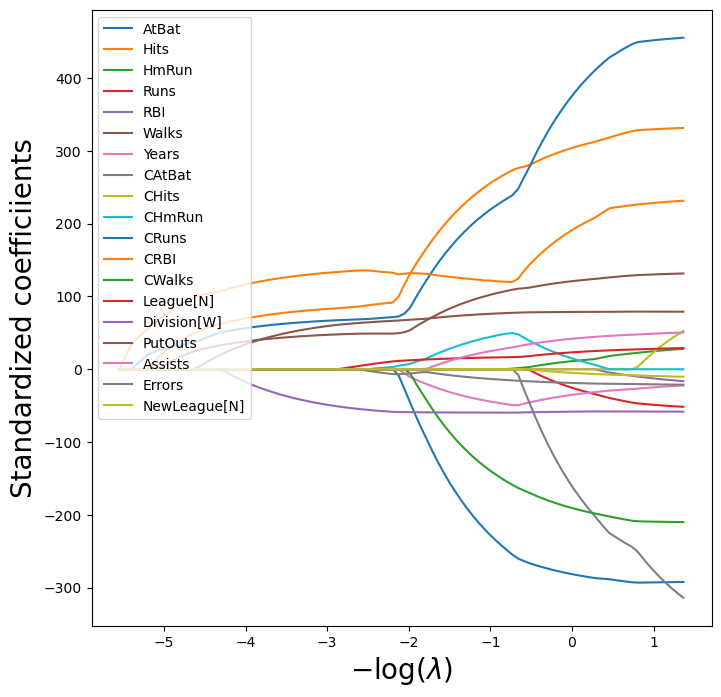

In [65]:
path_fig , ax = subplots(figsize =(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize =20)
ax.set_ylabel('Standardized coefficiients', fontsize =20);

In [66]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253639

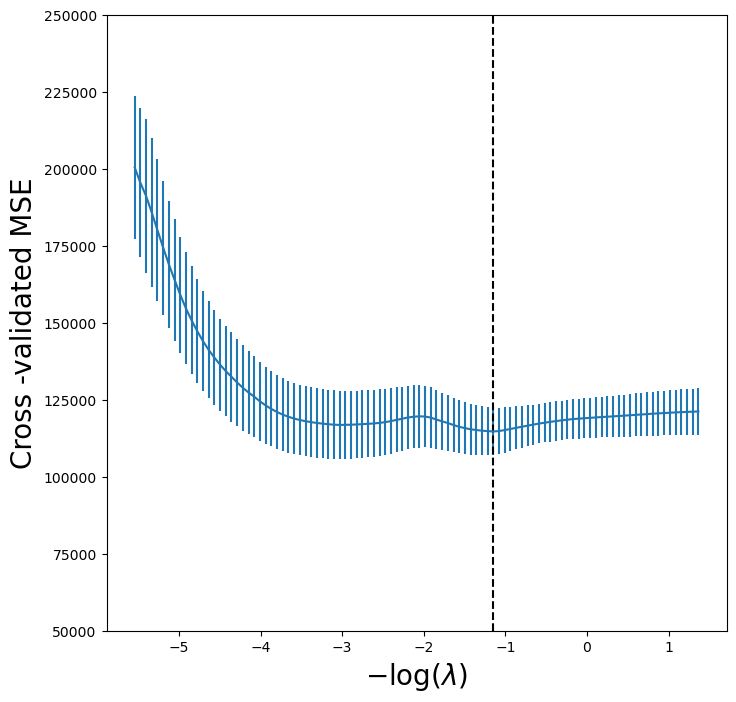

In [67]:
lassoCV_fig , ax = subplots(figsize =(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize =20)
ax.set_ylabel('Cross -validated MSE', fontsize =20);

In [68]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

# 6.5.3 PCR and PLS Regression
## Principal Components Regression

In [69]:
pca = PCA(n_components =2)
linreg = skl.LinearRegression()
pipe = Pipeline ([('pca', pca),
('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [70]:
pipe = Pipeline ([('scaler', scaler),
('pca', pca),
('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

(50000.0, 250000.0)

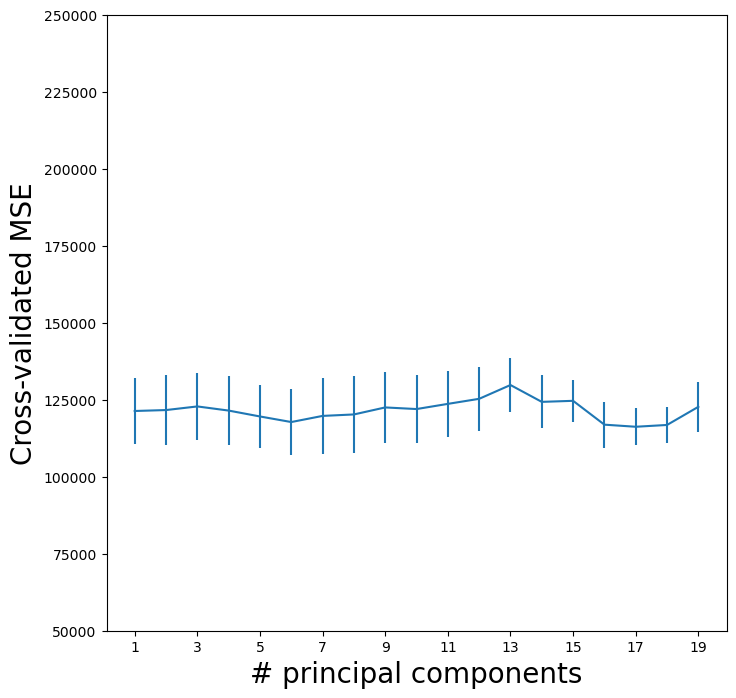

In [74]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']  # no trailing space here
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],  # no trailing space here
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000, 250000])


In [76]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
null_mse = -cv_null['test_score'].mean()
null_mse


204139.30692994667

In [77]:
pipe.named_steps['pca']. explained_variance_ratio_

array([0.3831424 , 0.21841076])

## Partial Least Squares (PLS)

In [83]:
from sklearn.cross_decomposition import PLSRegression

# Initialize the PLS regression model with 2 components
pls = PLSRegression(n_components=2, scale=True)

# Fit the model
pls.fit(X, Y)


PLSRegression()

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold

# Define the pipeline
pipe = Pipeline([
    ('pls', PLSRegression(scale=True))
])

# Define the param grid
param_grid = {'pls__n_components': range(1, 20)}

# Perform grid search
grid = GridSearchCV(pipe,
                    param_grid,
                    cv=kfold,
                    scoring='neg_mean_squared_error')

# Fit the model
grid.fit(X, Y)

# Access best parameters and estimator
print("Best n_components:", grid.best_params_['pls__n_components'])
print("Best model:", grid.best_estimator_)


Best n_components: 12
Best model: Pipeline(steps=[('pls', PLSRegression(n_components=12))])


(50000.0, 250000.0)

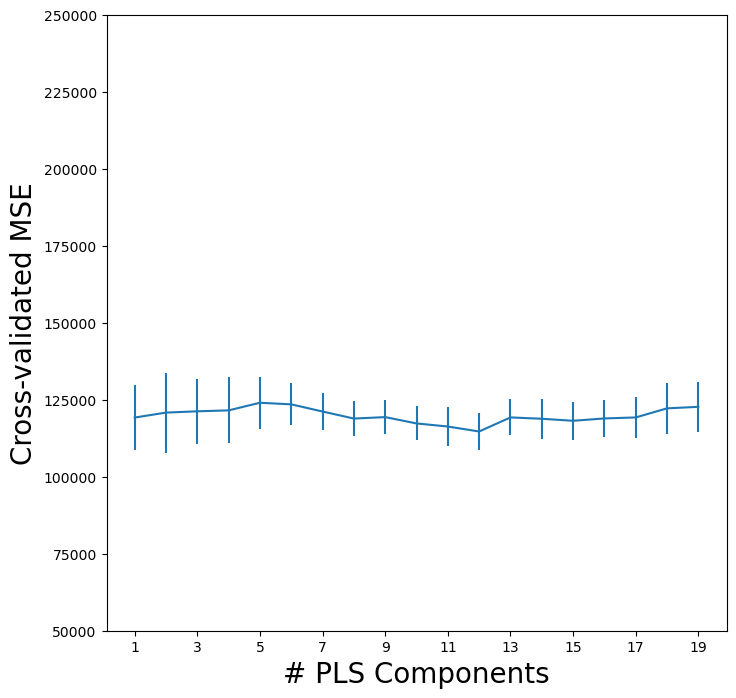

In [85]:
from matplotlib.pyplot import subplots
import numpy as np

pls_fig, ax = subplots(figsize=(8, 8))

n_comp = param_grid['pls__n_components']  # or 'n_components' if used directly
mean_scores = -grid.cv_results_['mean_test_score']  # fix the space
std_scores = grid.cv_results_['std_test_score'] / np.sqrt(kfold.get_n_splits())  # define K correctly

ax.errorbar(n_comp, mean_scores, yerr=std_scores)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# PLS Components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000, 250000])  # optional, adjust as needed


## 6.6 Exercises